In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/cropyield.xlsx",sheet_name='Sheet1')

Data PreProcessing


In [3]:
display(df.head())
display(df.info())

,Rain Fall (mm),Fertilizer,Temperatue,Nitrogen (N),Phosphorus (P),Potassium (K),Yeild (Q/acre)
0,1230.0,80.0,28,80.0,24.0,20.0,12.0
1,480.0,60.0,36,70.0,20.0,18.0,8.0
2,1250.0,75.0,29,78.0,22.0,19.0,11.0
3,450.0,65.0,35,70.0,19.0,18.0,9.0
4,1200.0,80.0,27,79.0,22.0,19.0,11.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rain Fall (mm)  99 non-null     float64
 1   Fertilizer      99 non-null     float64
 2   Temperatue      100 non-null    object 
 3   Nitrogen (N)    99 non-null     float64
 4   Phosphorus (P)  99 non-null     float64
 5   Potassium (K)   99 non-null     float64
 6   Yeild (Q/acre)  99 non-null     float64
dtypes: float64(6), object(1)
memory usage: 6.1+ KB


None

In [4]:
df = df.dropna()

In [5]:
display(df.head())
display(df.info())

,Rain Fall (mm),Fertilizer,Temperatue,Nitrogen (N),Phosphorus (P),Potassium (K),Yeild (Q/acre)
0,1230.0,80.0,28,80.0,24.0,20.0,12.0
1,480.0,60.0,36,70.0,20.0,18.0,8.0
2,1250.0,75.0,29,78.0,22.0,19.0,11.0
3,450.0,65.0,35,70.0,19.0,18.0,9.0
4,1200.0,80.0,27,79.0,22.0,19.0,11.0


<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 98
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rain Fall (mm)  99 non-null     float64
 1   Fertilizer      99 non-null     float64
 2   Temperatue      99 non-null     object 
 3   Nitrogen (N)    99 non-null     float64
 4   Phosphorus (P)  99 non-null     float64
 5   Potassium (K)   99 non-null     float64
 6   Yeild (Q/acre)  99 non-null     float64
dtypes: float64(6), object(1)
memory usage: 6.2+ KB


None

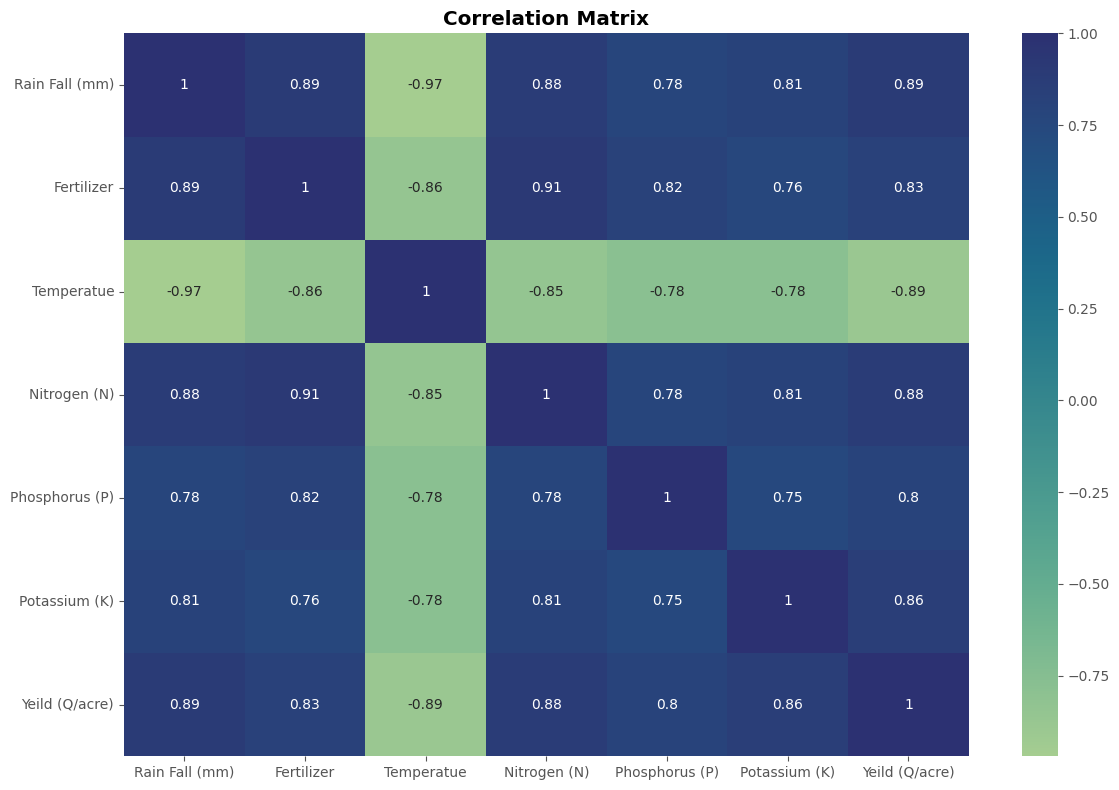

In [6]:
corr = df.corr()

plt.figure(figsize = (12,8))
sns.heatmap(corr.round(2), annot = True, cmap = 'crest')
plt.title('Correlation Matrix', fontweight = 'bold')

plt.tight_layout()
plt.show()

In [7]:
corr['Yeild (Q/acre)'].abs().sort_values(ascending = False).round(2)

,Yeild (Q/acre)
Yeild (Q/acre),1.00
Temperatue,0.89
Rain Fall (mm),0.89
Nitrogen (N),0.88
Potassium (K),0.86
Fertilizer,0.83
Phosphorus (P),0.80


In [8]:
FEATURES = df.drop('Yeild (Q/acre)', axis =1).columns

Using Models

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, OrthogonalMatchingPursuitCV

from xgboost import XGBRegressor

In [10]:
scaler = StandardScaler()

X = df[FEATURES]
y = df['Yeild (Q/acre)']

X_scaled = scaler.fit_transform(X)

Using 5 diff models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)

In [12]:
# 1 RandomForestRegressor
forest = XGBRegressor()
cross_val_score(forest, X_scaled, y).mean().round(2)

0.8

In [13]:
# 2 LinearRegression

reg = LinearRegression()
cross_val_score(reg, X_scaled, y).mean().round(2)

0.79

In [14]:
# 3 ElasticNet

net = ElasticNet()
cross_val_score(net, X_scaled, y).mean().round(2)

0.72

In [15]:
# 4 XGBRegressor

xgb = XGBRegressor()
cross_val_score(xgb, X_scaled, y).mean().round(2)

0.8

In [16]:
# 5 OrthogonalMatchingPursuitCV

omp = OrthogonalMatchingPursuitCV()
cross_val_score(omp, X_scaled, y).mean().round(2)

0.79

In [17]:
vc = VotingRegressor([('clf1', forest), ('clf2', reg), ('clf3', net), ('clf4', xgb), ('clf5', omp)])
cross_val_score(vc, X_scaled, y).mean()

0.8281292110918775

In [18]:
params = {'weights' : [(1,1,1,1,1),(1,1,1,1,2), (1,1,1,2,1), (1,1,2,1,1), (1,2,1,1,1), (2,1,1,1,1)]}

In [19]:
grid = GridSearchCV(vc, params)
grid.fit(X_scaled,y)
grid.best_params_

{'weights': (1, 1, 1, 2, 1)}

In [20]:
grid.best_score_

0.8286360846756871

In [21]:
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

sub = pd.DataFrame()
sub['Actual'] = y_test
sub['Predicted'] = y_pred

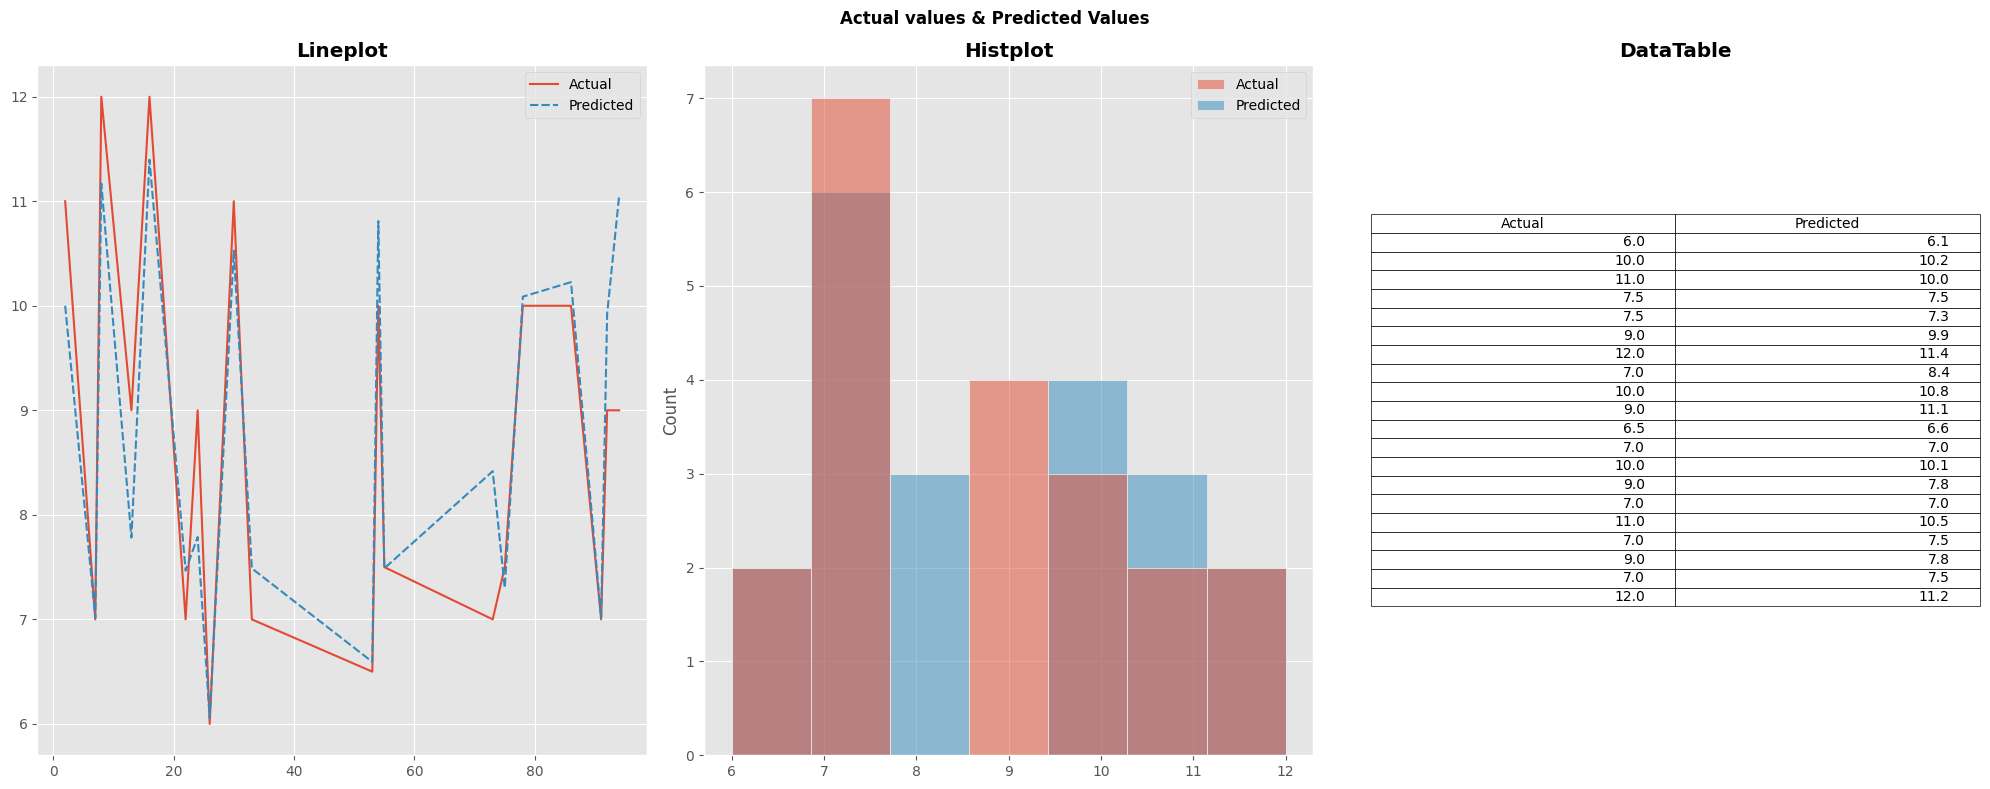

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

sns.lineplot(sub, ax=axs[0])
axs[0].set_title('Lineplot', fontweight='bold')

sns.histplot(sub, ax=axs[1])
axs[1].set_title('Histplot', fontweight='bold')

# Create DataTable
table_data = sub.values.round(1).tolist()
axs[2].axis('off')
axs[2].table(cellText=table_data, colLabels=sub.columns, loc='center')
axs[2].set_title('DataTable', fontweight='bold')

fig.suptitle('Actual values & Predicted Values', fontweight='bold')

plt.tight_layout()
plt.show()